# Algoritmo ALS para Recomendação On-line

Referência:

http://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering

http://www.slideshare.net/srowen/big-practical-recommendations-with-alternating-least-squares


## Objetivo

Entender a dinâmica do cálculo do ALS, testar alternativas para inicialização dos vetores de fatores latentes para novos usuários e novos documentos, testar alternativas para execução incremental do ALS.

In [1]:
using Gadfly
using DataFrames
set_default_plot_size(24cm, 16cm)

In [2]:
u = 1000 # Number of Users
i = 50   # Number of Items
d = 0.03 # Density of Preferences (3%) 
m = 10.0 # Max Preference value

println("Number of users: $u")
println("Number of itens: $i")
println("Density of preferences: $d")
println("Max preferences value: $m")

Number of users: 1000
Number of itens: 50
Density of preferences: 0.03
Max preferences value: 10.0


In [3]:
# random preferences (uniform distribution), users (lines) vs. items (columns)
A = rand(u,i)

1000x50 Array{Float64,2}:
 0.990264   0.859308    0.467028   …  0.333786    0.835455    0.736195 
 0.327241   0.210916    0.916521      0.416904    0.0912818   0.0146333
 0.792159   0.228078    0.713484      0.0421318   0.854199    0.575438 
 0.461448   0.0032999   0.0348478     0.28399     0.12342     0.0374335
 0.557257   0.955272    0.556037      0.820752    0.324365    0.272339 
 0.0984639  0.74643     0.340669   …  0.6077      0.230105    0.783961 
 0.292003   0.300662    0.979473      0.371941    0.464194    0.675672 
 0.608935   0.00737234  0.512034      0.510715    0.854969    0.847545 
 0.16311    0.882969    0.325909      0.429292    0.1705      0.0590495
 0.0869054  0.681665    0.782846      0.34276     0.67199     0.733537 
 0.156237   0.244924    0.549752   …  0.738394    0.969923    0.732676 
 0.299296   0.742152    0.14104       0.192106    0.609549    0.0479504
 0.745333   0.522485    0.13292       0.262885    0.457312    0.63079  
 ⋮                                 ⋱  

In [4]:
# binary matrix (A is 0-1 uniform, so number of trues is equal to 'd' percentage)  
B = A .< d

1000x50 BitArray{2}:
 false  false  false  false  false  …  false  false  false  false  false
 false  false  false  false  false     false  false  false  false   true
 false  false  false  false  false     false  false  false  false  false
 false   true  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false   true  false  …  false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false   true  false  false  false     false  false  false  false  false
 false  false  false  false  false     false   true  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false  …  false  false  false  false  false
 false  false  false  false  false     false   true  false  false  false
 false  false  false  false  false     false  false  false  false  false
     ⋮                        

In [5]:
# clean preferences (remove preferences above d)
C = A .* float(B)

1000x50 Array{Float64,2}:
 0.0  0.0         0.0  0.0         0.0  …  0.0         0.0         0.0      
 0.0  0.0         0.0  0.0         0.0     0.0         0.0         0.0146333
 0.0  0.0         0.0  0.0         0.0     0.0         0.0         0.0      
 0.0  0.0032999   0.0  0.0         0.0     0.0         0.0         0.0      
 0.0  0.0         0.0  0.0         0.0     0.0         0.0         0.0      
 0.0  0.0         0.0  0.00780701  0.0  …  0.0         0.0         0.0      
 0.0  0.0         0.0  0.0         0.0     0.0         0.0         0.0      
 0.0  0.00737234  0.0  0.0         0.0     0.0         0.0         0.0      
 0.0  0.0         0.0  0.0         0.0     0.0         0.0         0.0      
 0.0  0.0         0.0  0.0         0.0     0.0         0.0         0.0      
 0.0  0.0         0.0  0.0         0.0  …  0.0         0.0         0.0      
 0.0  0.0         0.0  0.0         0.0     0.0         0.0         0.0      
 0.0  0.0         0.0  0.0         0.0     0.0    

In [6]:
# scale preferences (all values are below d and scaled to max m)
P = ceil(C * m / d)

1000x50 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   5.0
 0.0  0.0  0.0  0.0  0.0  6.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  2.0  0.0  0.0  0.0  9.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  3.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  3.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  3.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  2.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 ⋮          

Number of Preferences: 1486


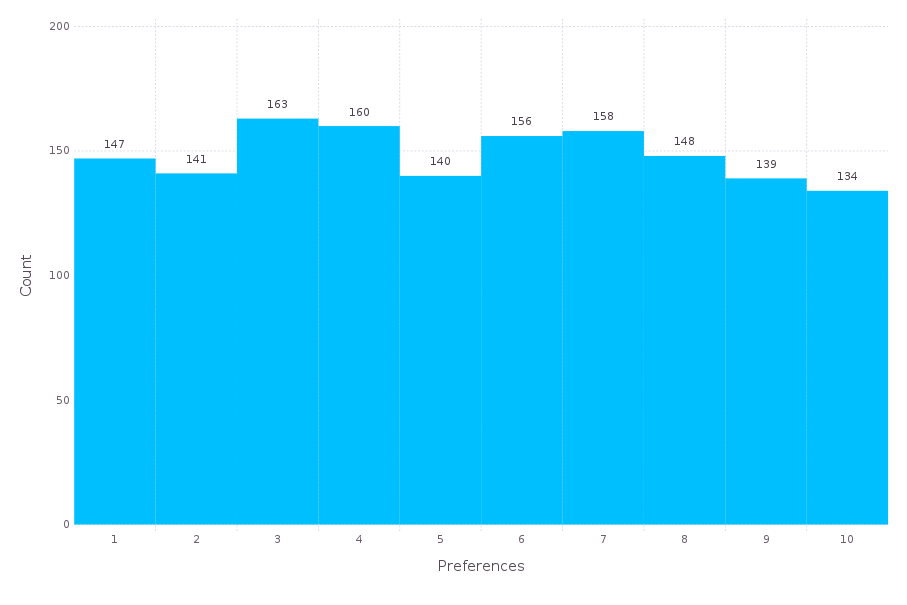

In [7]:
prefs = filter(v -> v != 0.0, P)
prefs = ifloor(prefs)

prefs_n = length(prefs)
bins = iceil(m)
x, y = hist(prefs, bins)

x = int(collect(x)[2:end])
x = map(string, x)

prefs_df = DataFrame(Preferences=x, Count=y, Label=map(string, y))
println("Number of Preferences: $prefs_n")
plot(prefs_df,
    x="Preferences",
    y="Count",
    label="Label",
    Geom.label(position=:above),
    Geom.bar,
    Scale.y_continuous(minvalue=0))

In [8]:
# users summary

s(t) = symbol(t)

function user_stats(U)
    items = length(U)
    pref_max = maximum(U)
    pref_min = minimum(U)
    pref_mean = mean(U)
    {
        s("Number Of Items") => items,
        s("Min Preference") => pref_min,
        s("Max Preference") => pref_max,
        s("Mean Preference") => pref_mean,
    }
end

users_prefs = [ filter(v -> v != 0.0, P[k,:]) for k in 1:size(P,1) ]
users_prefs = filter(v -> length(v) > 0, users_prefs)
users_stats = [ user_stats(U) for U in users_prefs ]

users_df = DataFrame(users_stats)
users_n = nrow(users_df)

println("Number of Users: $users_n")
println()
describe(users_df)

Number of Users: 781

Max Preference
Min      1.0
1st Qu.  5.0
Median   7.0
Mean     6.5723431498079385
3rd Qu.  9.0
Max      10.0
NAs      0
NA%      0.0%

Number Of Items
Min      1.0
1st Qu.  1.0
Median   2.0
Mean     1.9026888604353394
3rd Qu.  2.0
Max      7.0
NAs      0
NA%      0.0%

Min Preference
Min      1.0
1st Qu.  2.0
Median   4.0
Mean     4.2483994878361075
3rd Qu.  6.0
Max      10.0
NAs      0
NA%      0.0%

Mean Preference
Min      1.0
1st Qu.  3.6666666666666665
Median   5.5
Mean     5.404588134869825
3rd Qu.  7.0
Max      10.0
NAs      0
NA%      0.0%



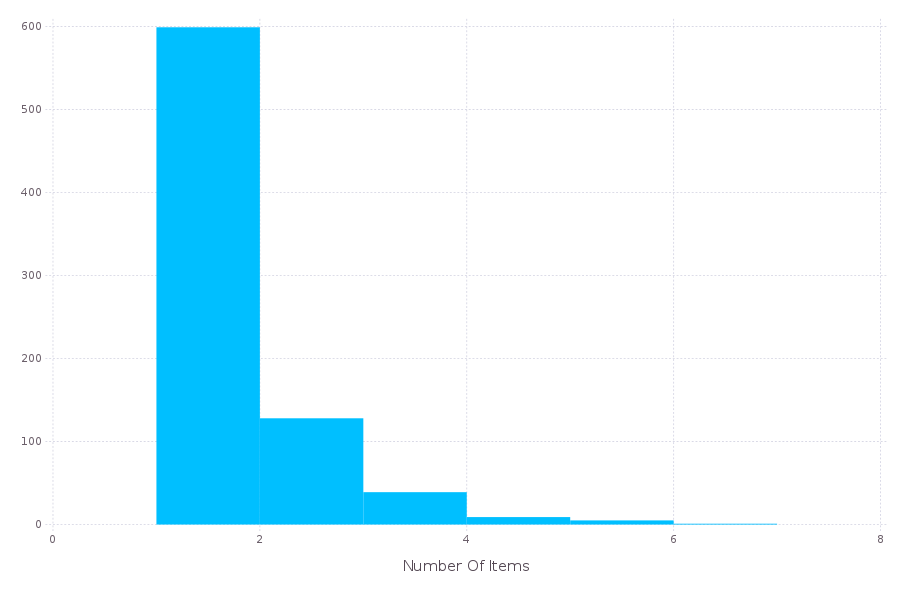

In [9]:
bins = maximum(users_df[s("Number Of Items")]) - minimum(users_df[s("Number Of Items")]) + 1
plot(users_df, x="Number Of Items", Geom.histogram(bincount=bins))

In [10]:
# items summary

function item_stats(I)
    users = length(I)
    pref_max = maximum(I)
    pref_min = minimum(I)
    pref_mean = mean(I)
    {
        s("Number Of Users") => users,
        s("Min Preference") => pref_min,
        s("Max Preference") => pref_max,
        s("Mean Preference") => pref_mean,
    }
end

items_prefs = [ filter(v -> v != 0.0, P[:,k]) for k in 1:size(P,2) ]
items_prefs = filter(v -> length(v) > 0, items_prefs)
items_stats = [ item_stats(I) for I in items_prefs ]

items_df = DataFrame(items_stats)

items_n = nrow(items_df)

println("Number of Items: $items_n")
println()
describe(items_df)

Number of Items: 50

Max Preference
Min      9.0
1st Qu.  10.0
Median   10.0
Mean     9.92
3rd Qu.  10.0
Max      10.0
NAs      0
NA%      0.0%

Number Of Users
Min      19.0
1st Qu.  27.0
Median   29.0
Mean     29.72
3rd Qu.  32.75
Max      40.0
NAs      0
NA%      0.0%

Min Preference
Min      1.0
1st Qu.  1.0
Median   1.0
Mean     1.04
3rd Qu.  1.0
Max      3.0
NAs      0
NA%      0.0%

Mean Preference
Min      4.108108108108108
1st Qu.  5.119047619047619
Median   5.466216216216216
Mean     5.431459736714492
3rd Qu.  5.75
Max      6.333333333333333
NAs      0
NA%      0.0%



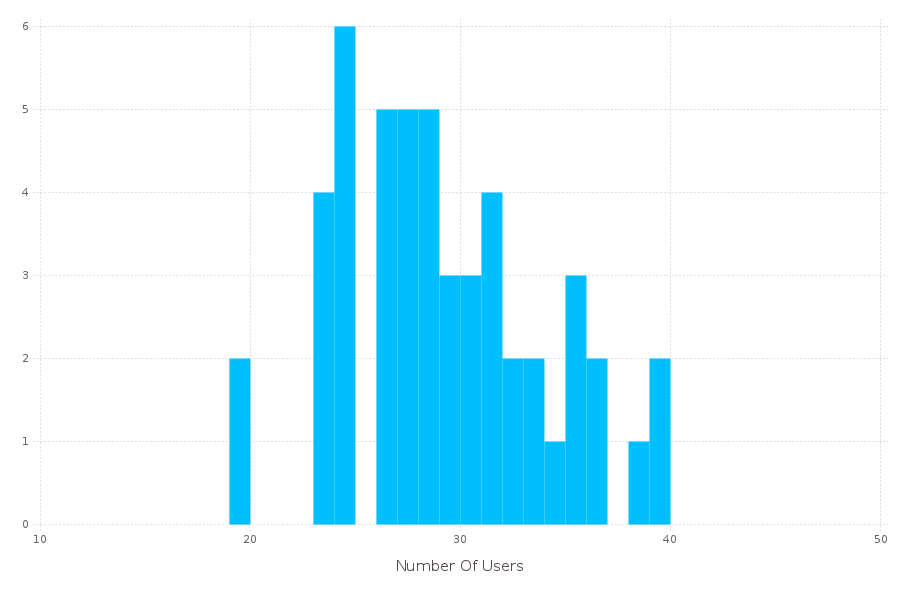

In [11]:
bins = maximum(items_df[s("Number Of Users")]) - minimum(items_df[s("Number Of Users")]) + 1
plot(items_df, x="Number Of Users", Geom.histogram(bincount=bins))

In [12]:
function mse(P, X, Y)
    M = float(P .> 0.0)
    E = P - M .* (X * Y')
    E2 = E .^ 2
    sum(E2) / countnz(P)
end

function als_plain(P, n_factors, n_iterations, λ)
    n_users, n_items = size(P)
    
    errors = Array(Float64, n_iterations)

    X = rand(n_users, n_factors)
    Y = rand(n_items, n_factors)

    reg = λ * eye(n_factors)
    for i in 1:n_iterations
        X = ((Y' * Y + reg) \ (Y' * P'))'
        Y = ((X' * X + reg) \ (X' * P))'
        errors[i] = mse(P, X, Y)
    end

    X, Y, errors
end

als_plain (generic function with 1 method)

In [13]:
factors = [10, 20, 100]
iterations = [10]
#iterations = [5, 15, 50]
lambdas = [0.01, 0.1, 1.0] 

testcases = vec([(f,i,λ) for f in factors, i in iterations, λ in lambdas])

new_result() = DataFrame([
    Int,     # Factors
    Int,     # Iterations
    Float64, # Lambda
    Float64, # Alpha
    Float64, # Last Error
    Float64, # Min Error
    Float64  # Max Error
    ], [
    :Factors,
    :Iterations,
    :λ,
    :α,
    :LastError,
    :MinError,
    :MaxError
], 0)

new_result (generic function with 1 method)

 10, I=10, λ=0.01 elapsed time: 1.691432036 seconds (75691916 bytes allocated, 8.65% gc time)
 20, I=10, λ=0.01 elapsed time: 0.147972722 seconds (33547624 bytes allocated, 56.25% gc time)
 100, I=10, λ=0.01 elapsed time: 0.182759518 seconds (59146120 bytes allocated, 45.15% gc time)
 10, I=10, λ=0.1 elapsed time: 0.164315995 seconds (30796168 bytes allocated, 50.05% gc time)
 20, I=10, λ=0.1 elapsed time: 0.16829206 seconds (33547608 bytes allocated, 49.42% gc time)
 100, I=10, λ=0.1 elapsed time: 0.199762328 seconds (59146120 bytes allocated, 41.14% gc time)
 10, I=10, λ=1.0 elapsed time: 0.159326067 seconds (30796152 bytes allocated, 51.90% gc time)
 20, I=10, λ=1.0 elapsed time: 0.082670046 seconds (33547608 bytes allocated)
 100, I=10, λ=1.0 elapsed time: 0.262331921 seconds (59146136 bytes allocated, 62.95% gc time)
9x7 DataFrame
| Row | Factors | Iterations | λ    | α   | LastError   | MinError    |
|-----|---------|------------|------|-----|-------------|-------------|
| 1   | 

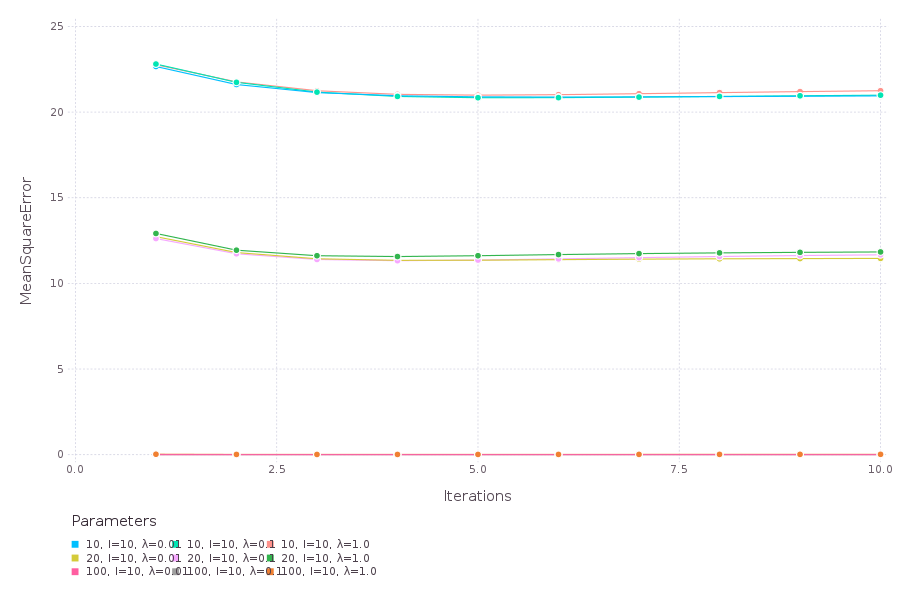

In [14]:
result = new_result()

g = Array(Layer, 0)

for (f, i, λ) in testcases
    params = " $f, I=$i, λ=$λ "
    print(params)

    @time _, _, errors = als_plain(P, f, i, λ)

    last = errors[i]
    min = minimum(errors)
    max = maximum(errors)

    push!(result, [f, i, λ, 0.0, last, min, max])
            
    params = " $f, I=$i, λ=$λ "
    df = DataFrame(Iterations=1:i, MeanSquareError=errors, Parameters=params)
    pl = layer(df, x=:Iterations, y=:MeanSquareError, color=:Parameters, Geom.line, Geom.point)
    push!(g, pl...)
end

sort!(result, cols = :MinError)

println(result)

plot(g, Theme(key_position=:bottom))

In [15]:
function als_weighted(P, n_factors, n_iterations, λ)
    n_users, n_items = size(P)
    
    errors = Array(Float64, n_iterations)

    X = rand(n_users, n_factors)
    Y = rand(n_items, n_factors)
    
    W = float(P .> 0.0)
    Wu = [diagm(vec(W[k,:])) for k in 1:n_users]
    Wi = [diagm(W[:,k]) for k in 1:n_items]
    
    Pu = [vec(P[k,:]) for k in 1:n_users]
    Pi = [P[:,k] for k in 1:n_items]
    
    reg = λ * eye(n_factors)
    for i in 1:n_iterations
        for k in 1:n_users
            Wuk = Wu[k]
            X[k,:] = ((Y' * Wuk * Y + reg) \ (Y' * Wuk * Pu[k]))'
        end
        for k in 1:n_items
            Wik = Wi[k]
            Y[k,:] = ((X' * Wik * X + reg) \ (X' * Wik * Pi[k]))'
        end
        errors[i] = mse(P, X, Y)
    end

    X, Y, errors
end

als_weighted (generic function with 1 method)

 10, I=10, λ=0.01 elapsed time: 5.149990907 seconds (823101012 bytes allocated, 5.08% gc time)
 20, I=10, λ=0.01 elapsed time: 6.552828966 seconds (1207137240 bytes allocated, 24.75% gc time)
 100, I=10, λ=0.01 elapsed time: 21.582933278 seconds (6057715752 bytes allocated, 44.07% gc time)
 10, I=10, λ=0.1 elapsed time: 4.276888368 seconds (812929304 bytes allocated, 8.02% gc time)
 20, I=10, λ=0.1 elapsed time: 5.662141219 seconds (1207137240 bytes allocated, 25.50% gc time)
 100, I=10, λ=0.1 elapsed time: 20.590373474 seconds (6057715752 bytes allocated, 45.58% gc time)
 10, I=10, λ=1.0 elapsed time: 4.416750409 seconds (812929320 bytes allocated, 7.55% gc time)
 20, I=10, λ=1.0 elapsed time: 6.094383528 seconds (1207137240 bytes allocated, 22.71% gc time)
 100, I=10, λ=1.0 elapsed time: 22.07546112 seconds (6057715752 bytes allocated, 43.25% gc time)
9x7 DataFrame
| Row | Factors | Iterations | λ    | α   | LastError   | MinError    |
|-----|---------|------------|------|-----|-----

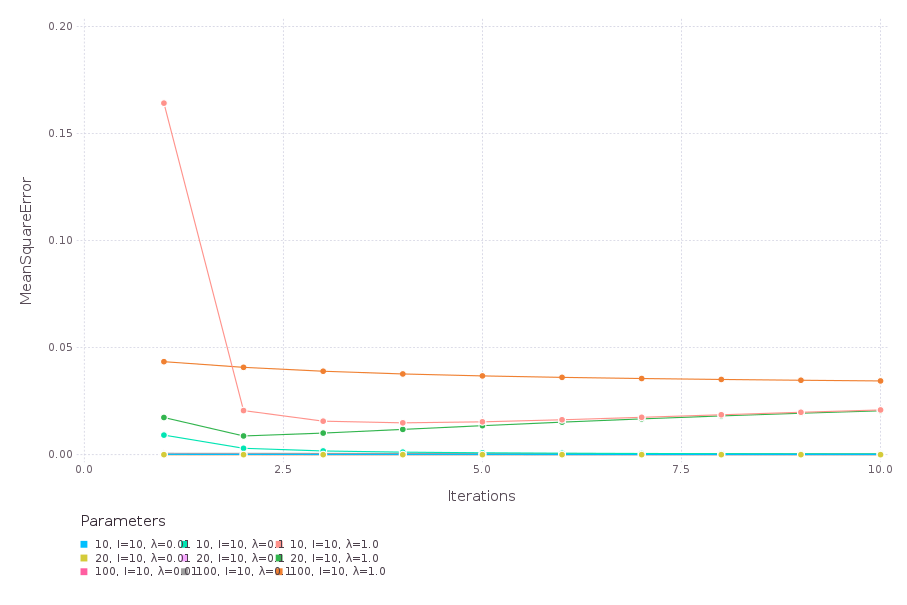

In [16]:
result = new_result()

g = Array(Layer, 0)

for (f, i, λ) in testcases
    params = " $f, I=$i, λ=$λ "
    print(params)
    
    @time _, _, errors = als_weighted(P, f, i, λ)

    last = errors[i]
    min = minimum(errors)
    max = maximum(errors)

    push!(result, [f, i, λ, 0.0, last, min, max])

    df = DataFrame(Iterations=1:i, MeanSquareError=errors, Parameters=params)
    pl = layer(df, x=:Iterations, y=:MeanSquareError, color=:Parameters, Geom.line, Geom.point)
    push!(g, pl...)
end

sort!(result, cols = :MinError)

println(result)

plot(g, Theme(key_position=:bottom))

In [17]:
function als_implicit(R, n_factors, n_iterations, λ, α)
    n_users, n_items = size(R)
    
    errors = Array(Float64, n_iterations)

    X = rand(n_users, n_factors)
    Y = rand(n_items, n_factors)
    
    P = float(R .> 0.0)

    C = P + α * R
    Cu = [diagm(vec(C[k,:])) for k in 1:n_users]
    Ci = [diagm(C[:,k]) for k in 1:n_items]
    
    Pu = [vec(P[k,:]) for k in 1:n_users]
    Pi = [P[:,k] for k in 1:n_items]
    
    reg = λ * eye(n_factors)
    for i in 1:n_iterations
        for k in 1:n_users
            Cuk, Puk = Cu[k], Pu[k]
            X[k,:] = ((Y' * Cuk * Y + reg) \ (Y' * Cuk * Puk))'
        end
        for k in 1:n_items
            Cik, Pik = Ci[k], Pi[k]
            Y[k,:] = ((X' * Cik * X + reg) \ (X' * Cik * Pik))'
        end
        errors[i] = mse(P, X, Y)
    end

    X, Y, errors
end

als_implicit (generic function with 1 method)

 10, I=20, λ=0.01, α=0.0 elapsed time: 8.683469025 seconds (1208527808 bytes allocated, 4.88% gc time)
 10, I=20, λ=1.0, α=0.0 elapsed time: 8.637458943 seconds (1203347576 bytes allocated, 5.00% gc time)
 10, I=20, λ=10.0, α=0.0 elapsed time: 8.392891314 seconds (1203347576 bytes allocated, 3.97% gc time)
 10, I=20, λ=0.01, α=0.01 elapsed time: 8.486243677 seconds (1203347592 bytes allocated, 5.23% gc time)
 10, I=20, λ=1.0, α=0.01 elapsed time: 8.237385708 seconds (1203347576 bytes allocated, 5.23% gc time)
 10, I=20, λ=10.0, α=0.01 elapsed time: 8.060152738 seconds (1203347592 bytes allocated, 4.10% gc time)
 10, I=20, λ=0.01, α=2.0 elapsed time: 8.411135235 seconds (1203347592 bytes allocated, 5.26% gc time)
 10, I=20, λ=1.0, α=2.0 elapsed time: 8.086412126 seconds (1203347576 bytes allocated, 5.39% gc time)
 10, I=20, λ=10.0, α=2.0 elapsed time: 7.966372853 seconds (1203347576 bytes allocated, 4.15% gc time)
 10, I=20, λ=0.01, α=50.0 elapsed time: 8.238901437 seconds (1203347576 b

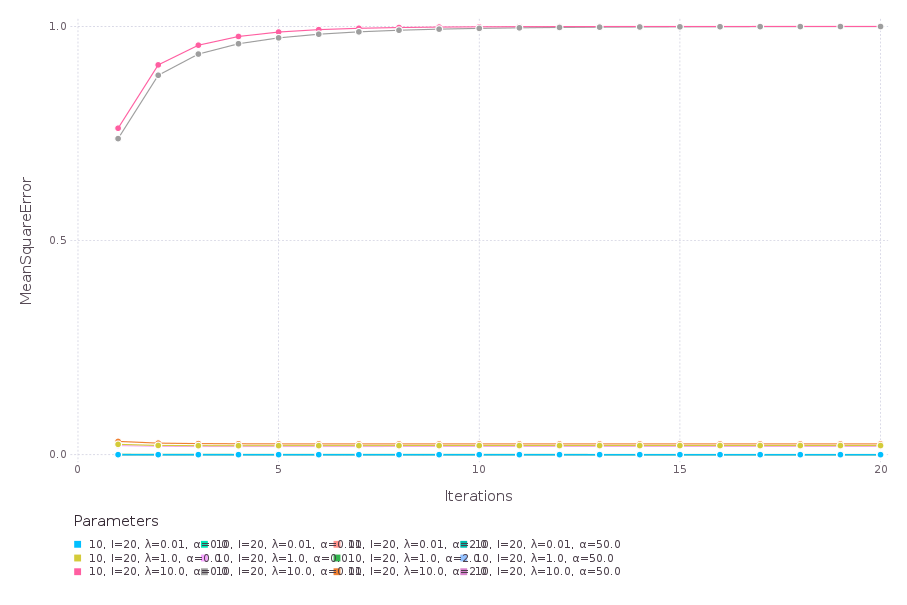

In [18]:
result = new_result()

g = Array(Layer, 0)

implicit_tests = vec([(f,20,λ,α) for f in 10, λ in [0.01,1.0,10.0], α in [0.,0.01,2.,50.]])

for (f, i, λ, α) in implicit_tests
    params = " $f, I=$i, λ=$λ, α=$α "
    print(params)
    
    @time _, _, errors = als_implicit(P, f, i, λ, α)

    last = errors[i]
    min = minimum(errors)
    max = maximum(errors)

    push!(result, [f, i, λ, α, last, min, max])

    df = DataFrame(Iterations=1:i, MeanSquareError=errors, Parameters=params)
    pl = layer(df, x=:Iterations, y=:MeanSquareError, color=:Parameters, Geom.line, Geom.point)
    push!(g, pl...)
end

sort!(result, cols = :LastError)

println(result)

plot(g, Theme(key_position=:bottom))